# DEG error analysis

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import upath
import extras

loading extras module


In [3]:
import logging

format_str = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(filename="plot_roc_curves.log", format=format_str)
# logging.getLogger("gcsfs").setLevel(logging.INFO)
# logging.getLogger("fsspec").setLevel(logging.INFO)
logging.getLogger("extras").setLevel("DEBUG")
logging.captureWarnings(True)

In [4]:
path_root = upath.UPath("gs://liulab/differential_composition_and_expression/20230317_06h00m45s")
# print(extras.get_parquet_paths(path_root))
# !gsutil ls "{path_root}/*"

In [5]:
df_gene_stats = extras.load_gene_stats(path_root)

### checking pvals

False    16036
True        27
Name: significant_bh_fdr=0.10, dtype: int64


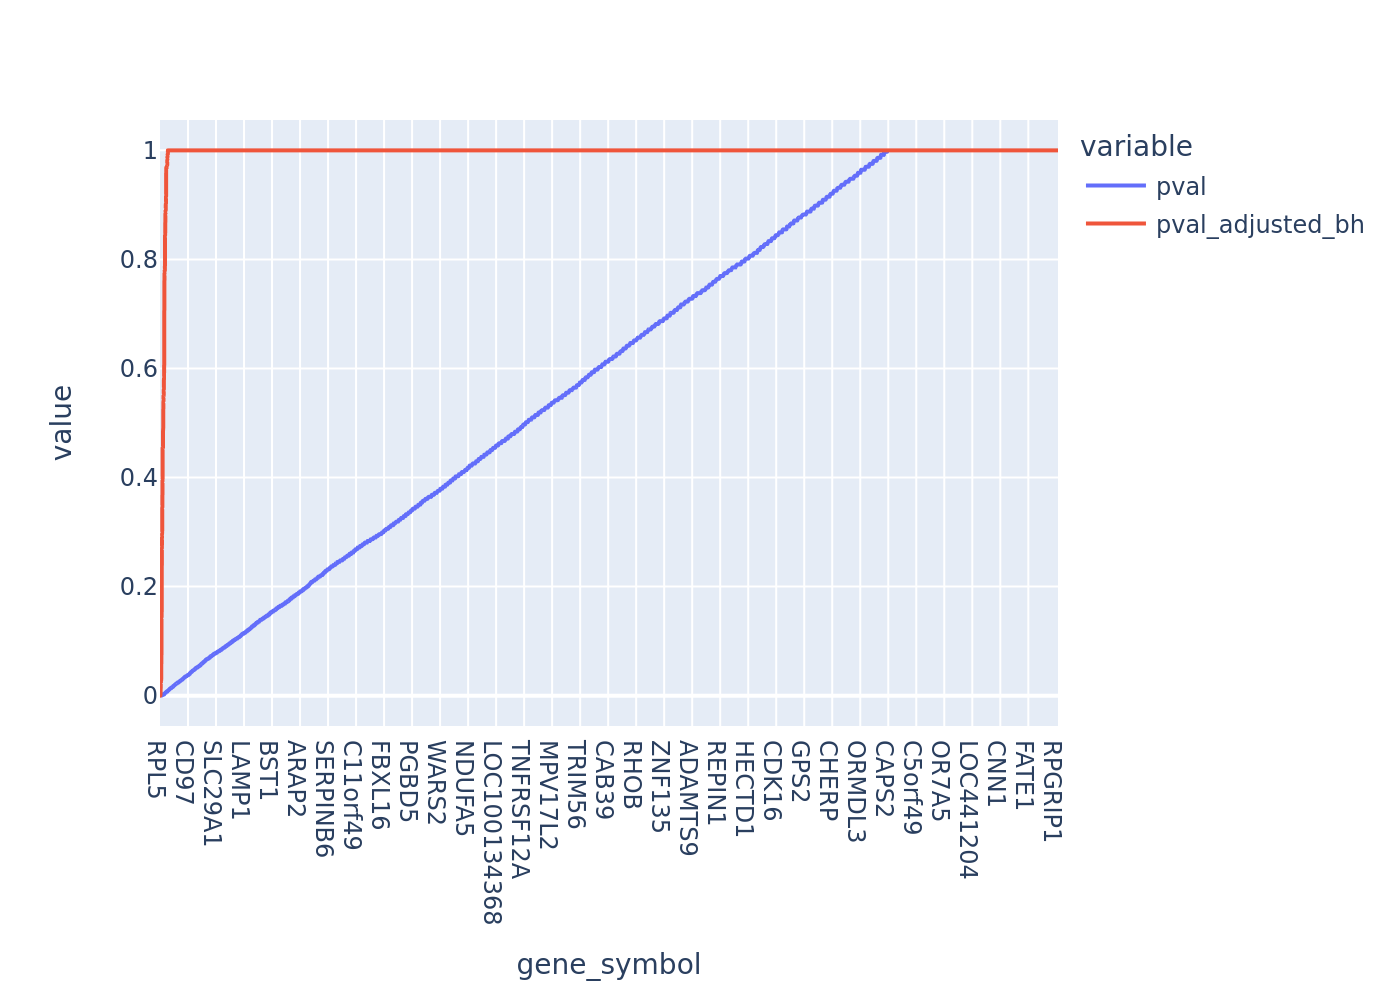

In [6]:
subset_gene_stats = df_gene_stats.loc["malignant_cibersortx", "0.72,0.7", "1.00", "04"]
# subset_gene_stats[columns].sort_values(by="-log10_pval_adjusted_bh", ascending=False)
print(subset_gene_stats["significant_bh_fdr=0.10"].value_counts())

columns = [
    "pval",
    # "-log10_pval",
    # "-log10_pval_signed_directional",
    "pval_adjusted_bh",
    # "-log10_pval_adjusted_bh",
    # "-log10_pval_adjusted_bh_signed_directional",
]
fig = px.line(
    subset_gene_stats.sort_values("pval").reset_index(),
    x="gene_symbol",
    y=columns,
)
fig.show(renderer="png", scale=2)

### volcanos for all experiment setups

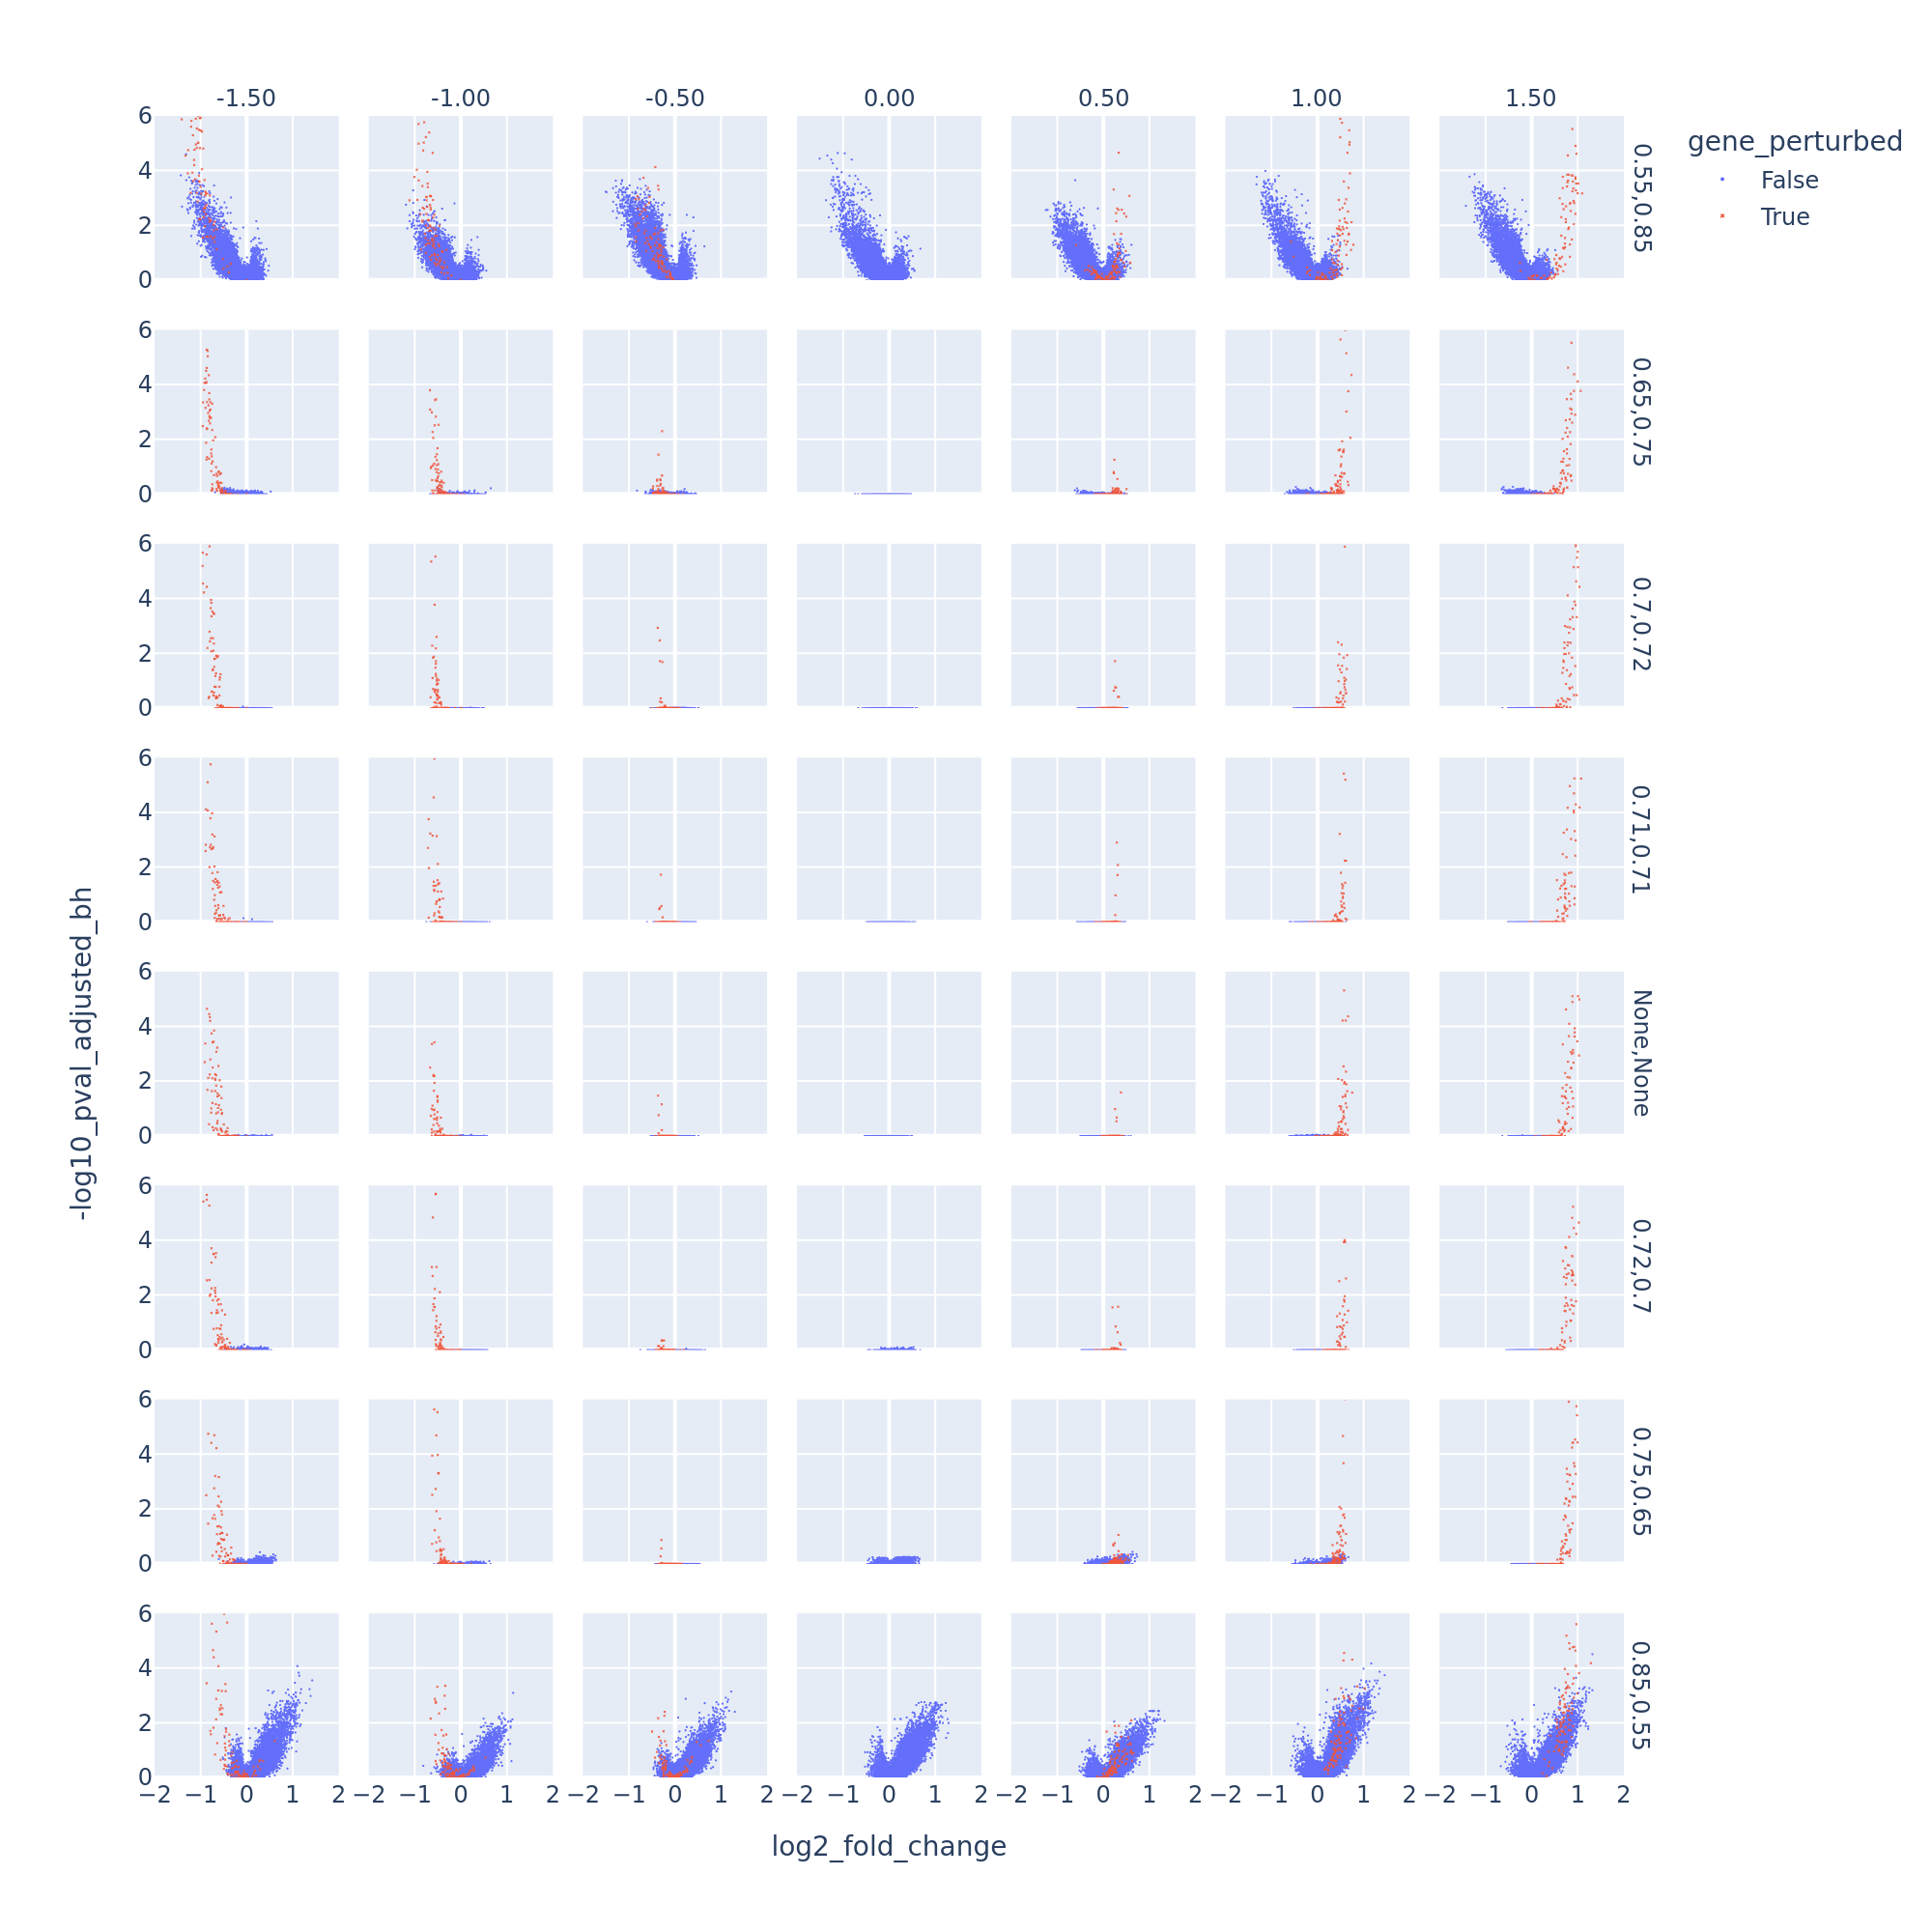

In [7]:
df_to_plot = df_gene_stats.xs("malignant_cibersortx", level="origin", drop_level=False)
fig = extras.make_volcano_grid_scatter(df_to_plot)
fig.show(renderer="png", scale=2)

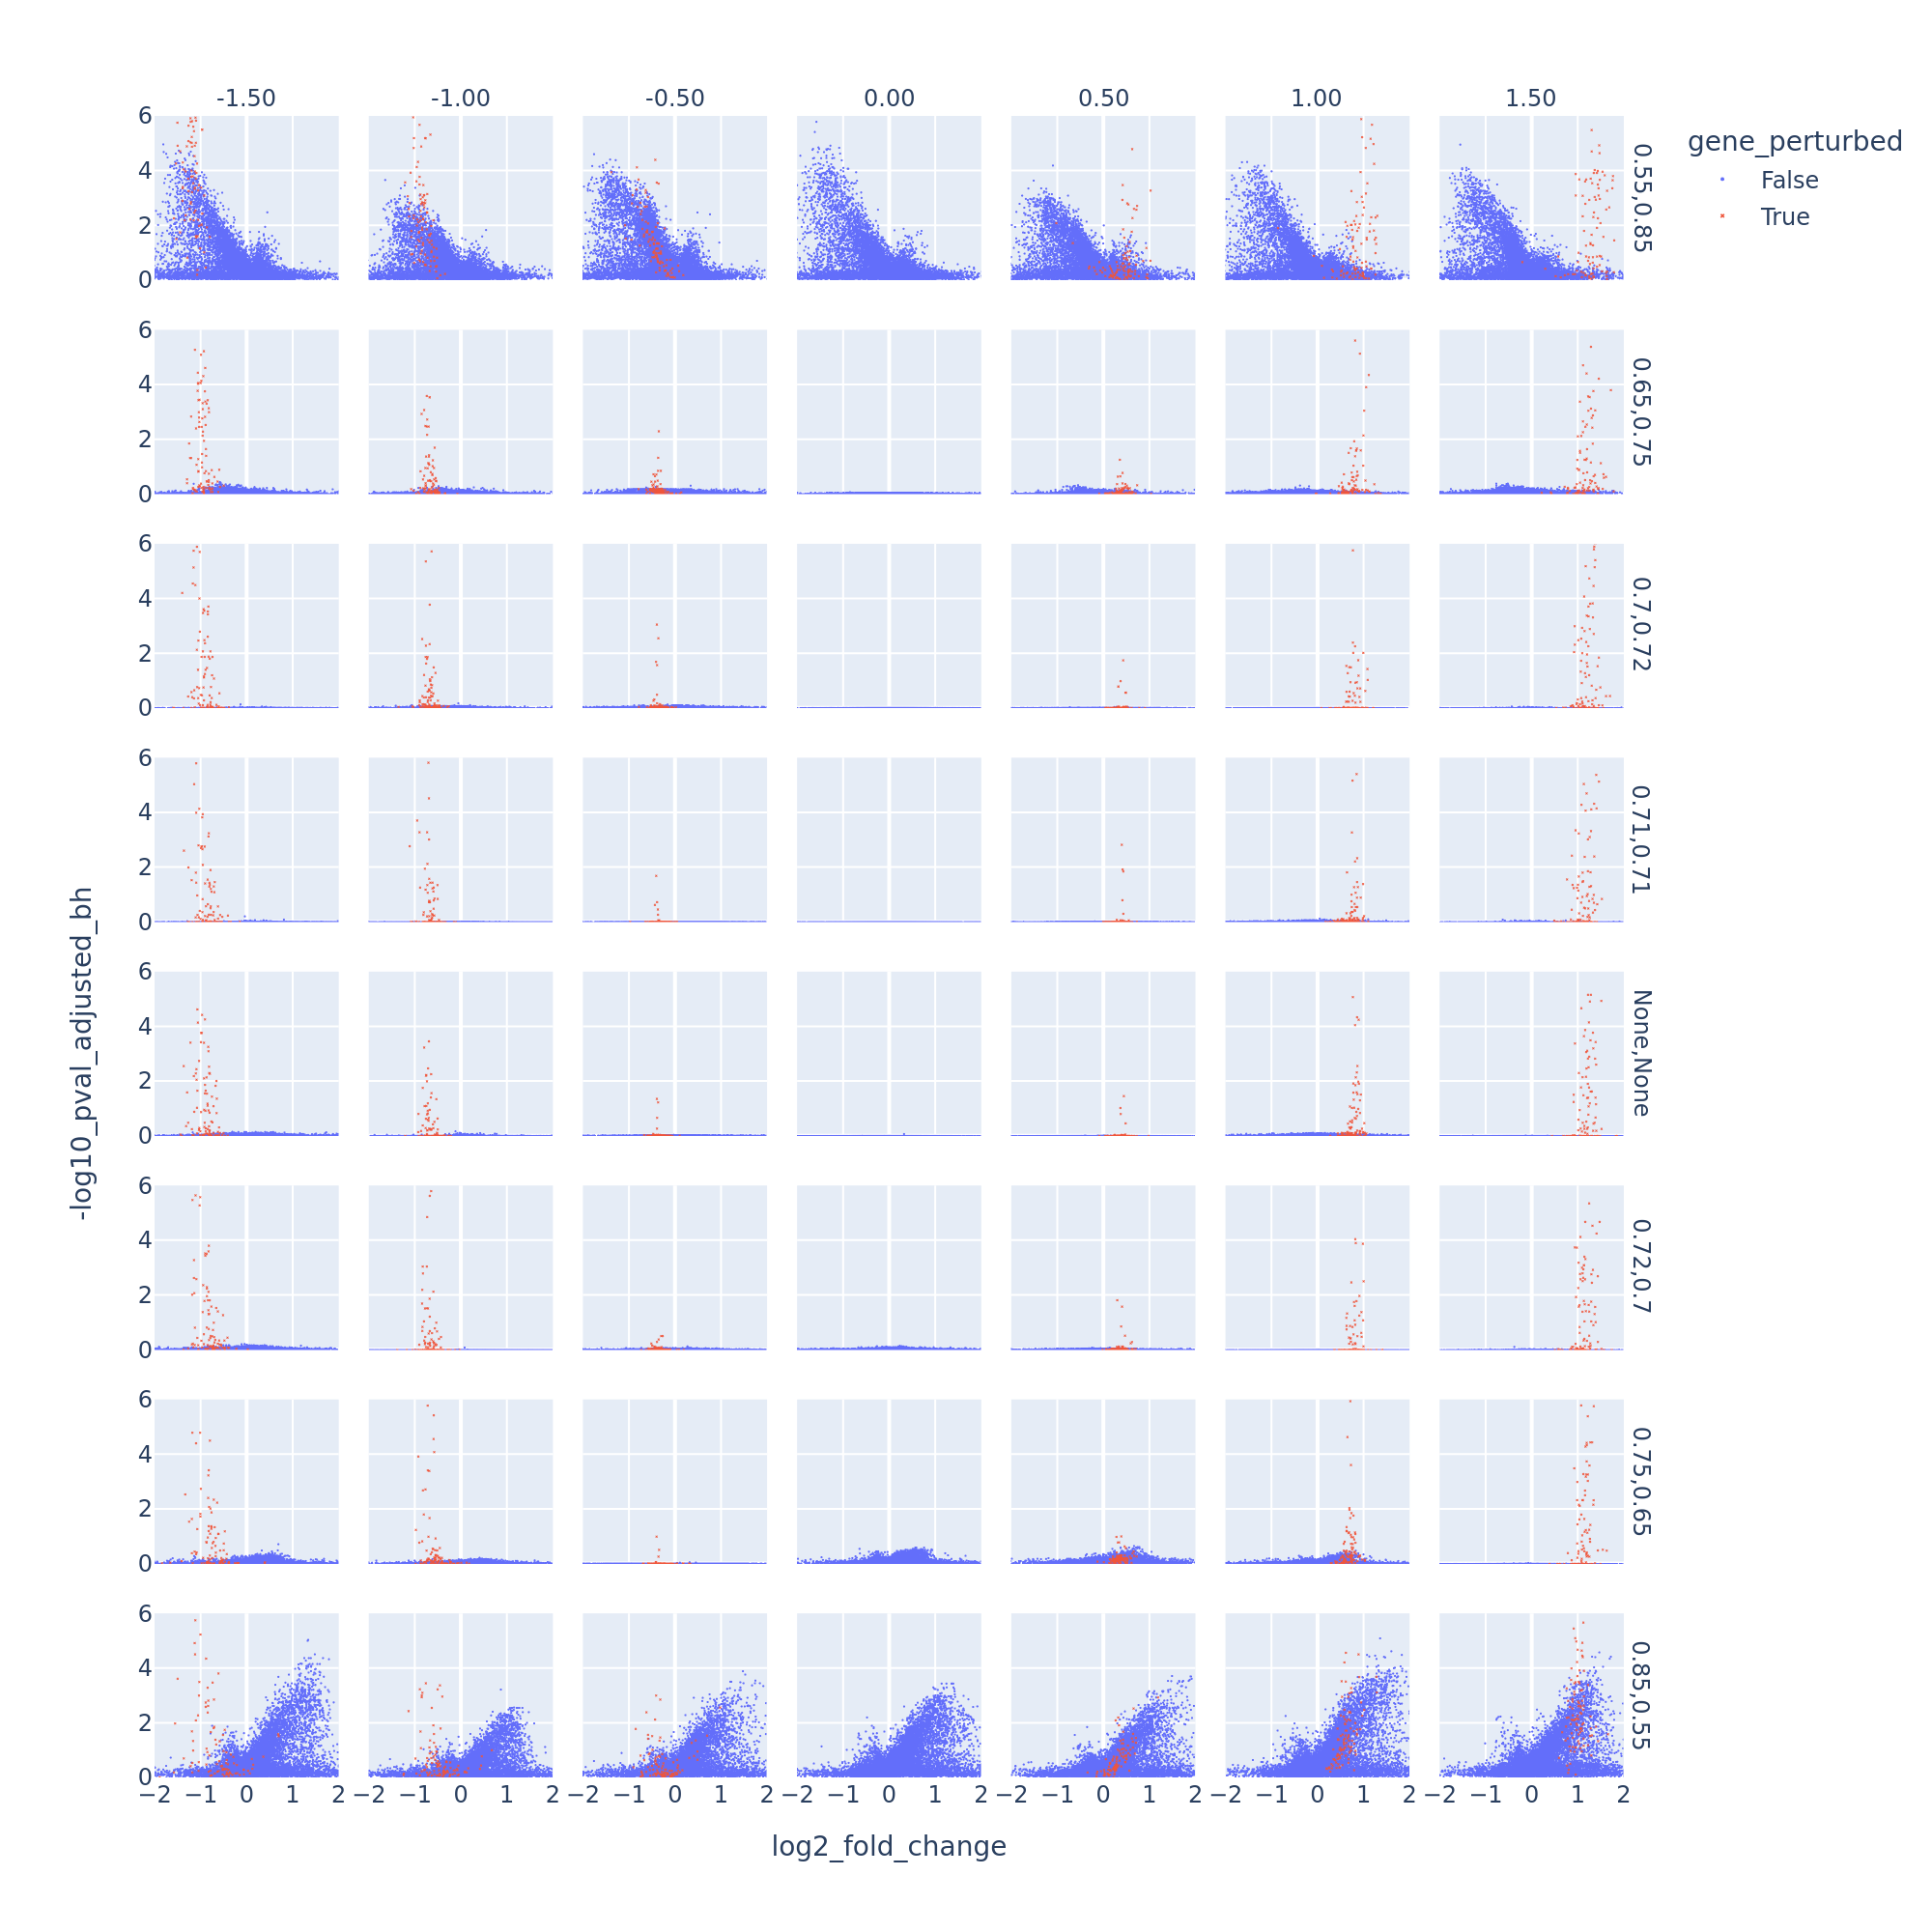

In [8]:
df_to_plot = df_gene_stats.xs("bulk", level="origin", drop_level=False)
fig = extras.make_volcano_grid_scatter(df_to_plot)
fig.show(renderer="png", scale=2)

## ROC, PPV, etc by p-value thresholds

In [9]:
# score_column = "-log10_pval_signed_directional"
score_column = "-log10_pval_adjusted_bh_signed_directional"

In [10]:
df = (
    df_gene_stats
    .loc[df_gene_stats.index.get_level_values("log2_fc") != "0.00"]
    .xs("malignant_cibersortx", level="origin", drop_level=False)
    # 
)
df_roc_curves, df_roc_auc_scores = extras.calculate_roc(df, score_column)
df_precision_recall_curves, df_precision = extras.calculate_precision_and_recall(df, score_column)

### ROC (TPR & FPR)

In [11]:
extras.make_table_scores(df_roc_auc_scores)

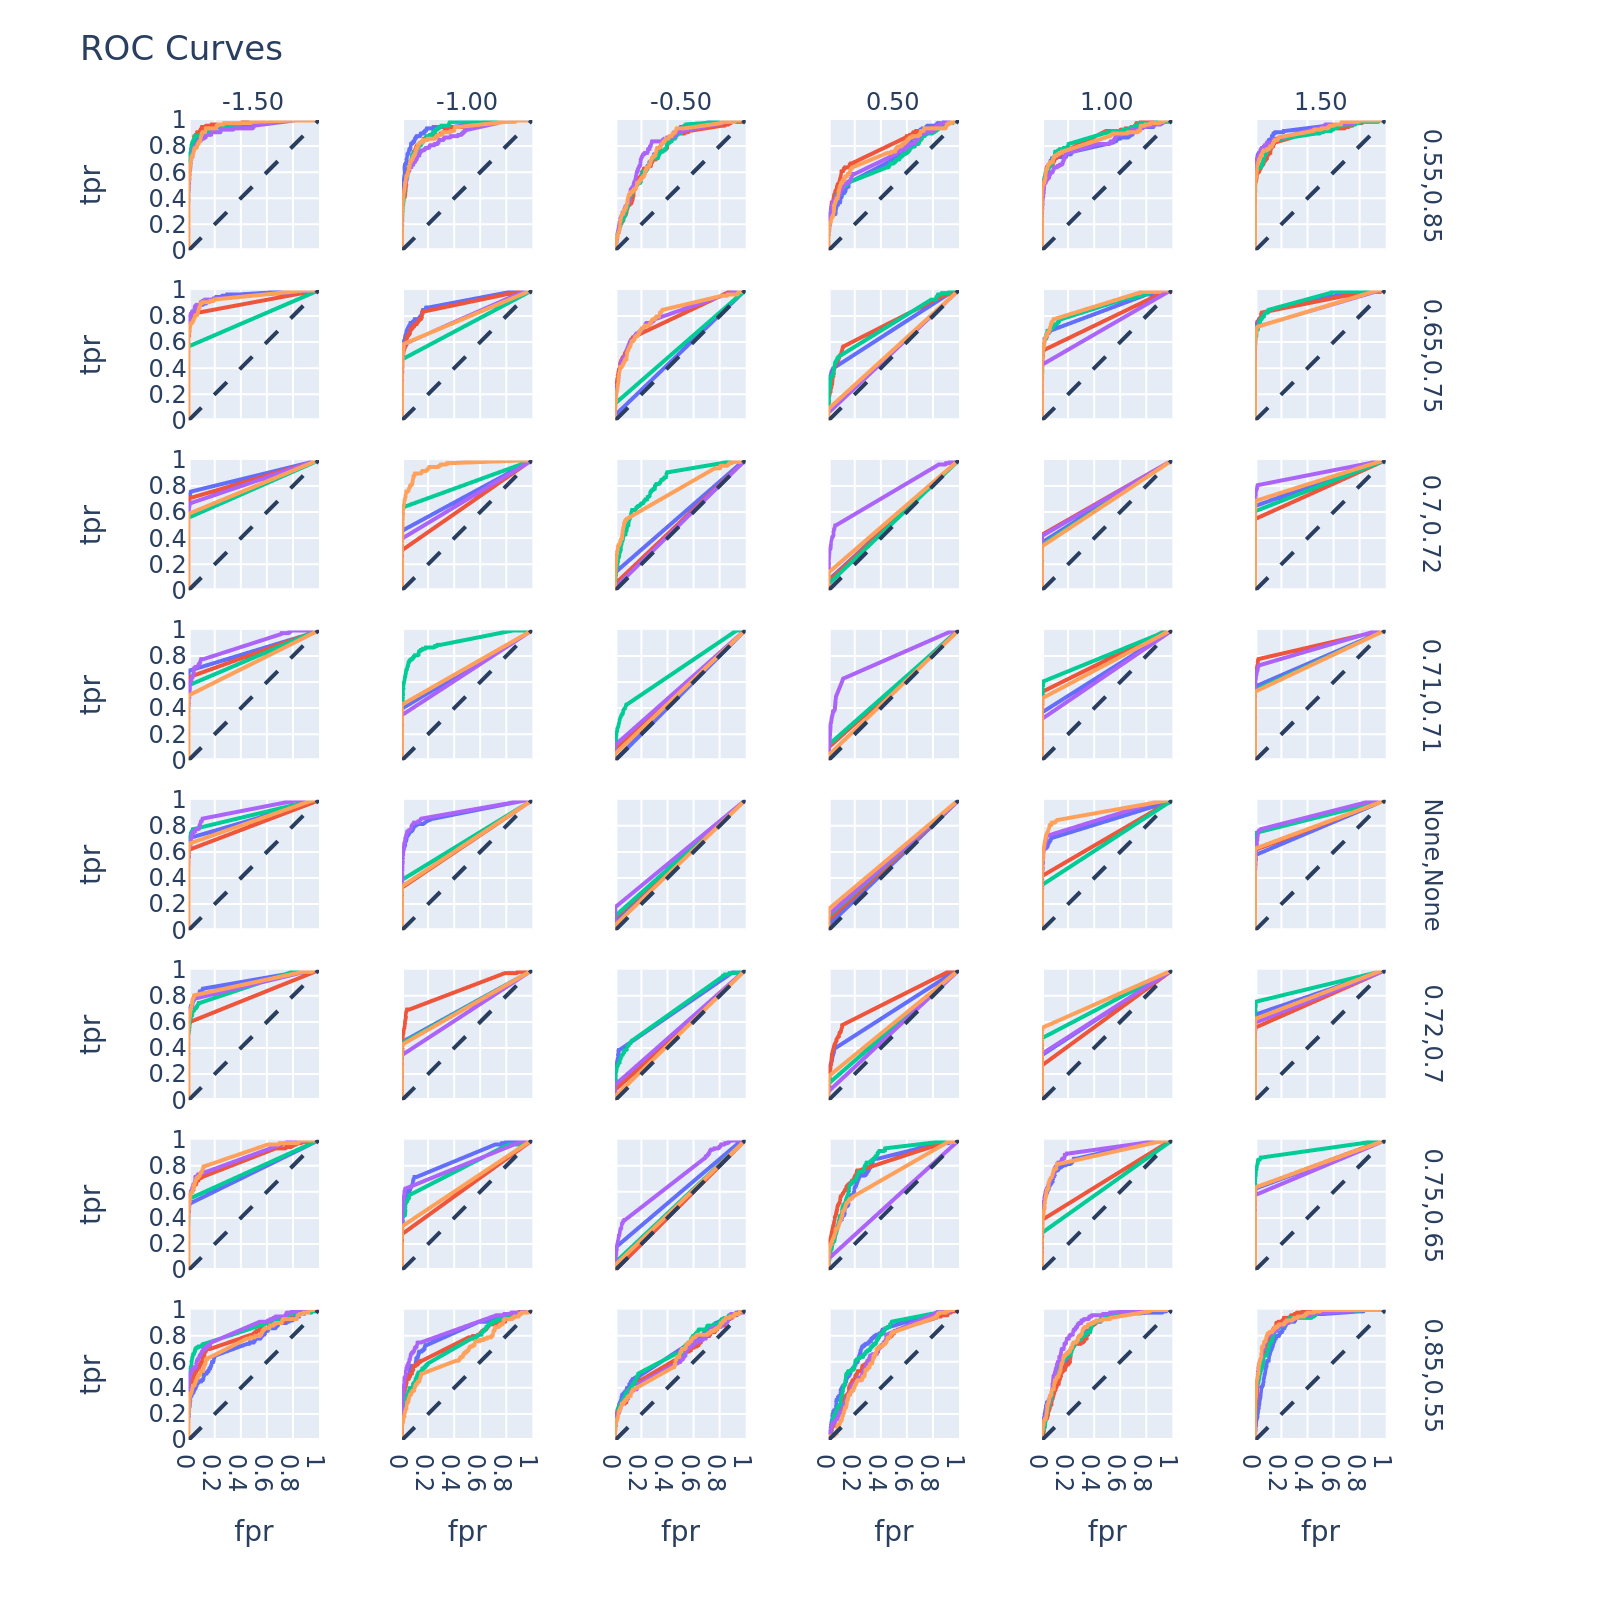

In [12]:
fig = extras.plot_roc(df_roc_curves)
fig.show(renderer="png", scale=2)

### PPV (precision)

In [13]:
extras.make_table_scores(df_precision)

In [14]:
extras.make_table_scores_with_stddev(df_precision)

loading extras module


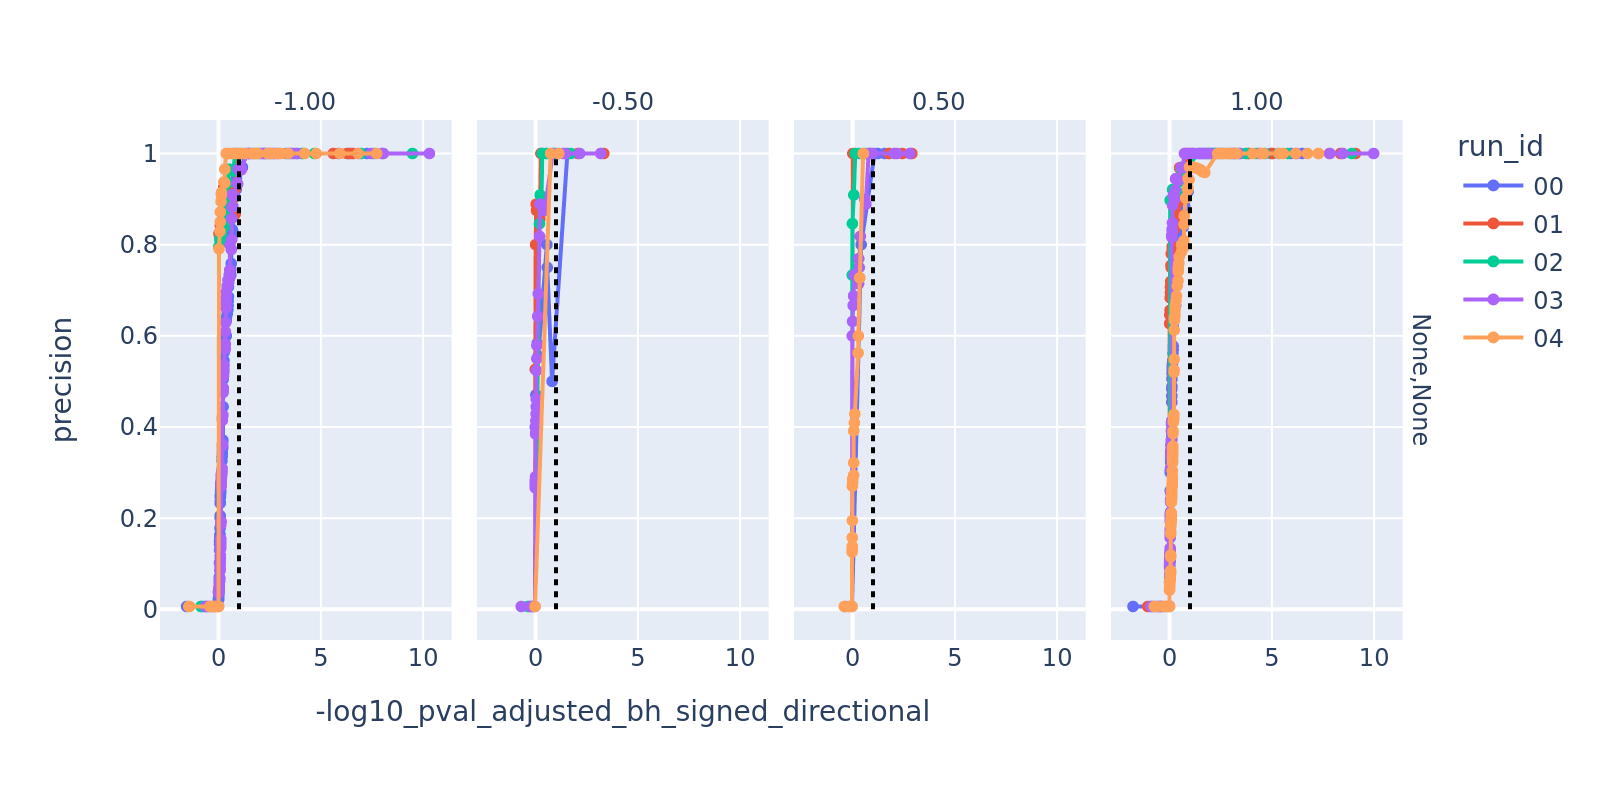

In [20]:
df_to_plot = (
    df_precision_recall_curves
    .xs("None,None", level="malignant_means", drop_level=False)
    # .xs("1.50", level="log2_fc", drop_level=False)
    .loc[:, :, "-1.00":"1.00", :]
)
fig = extras.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)
# fig

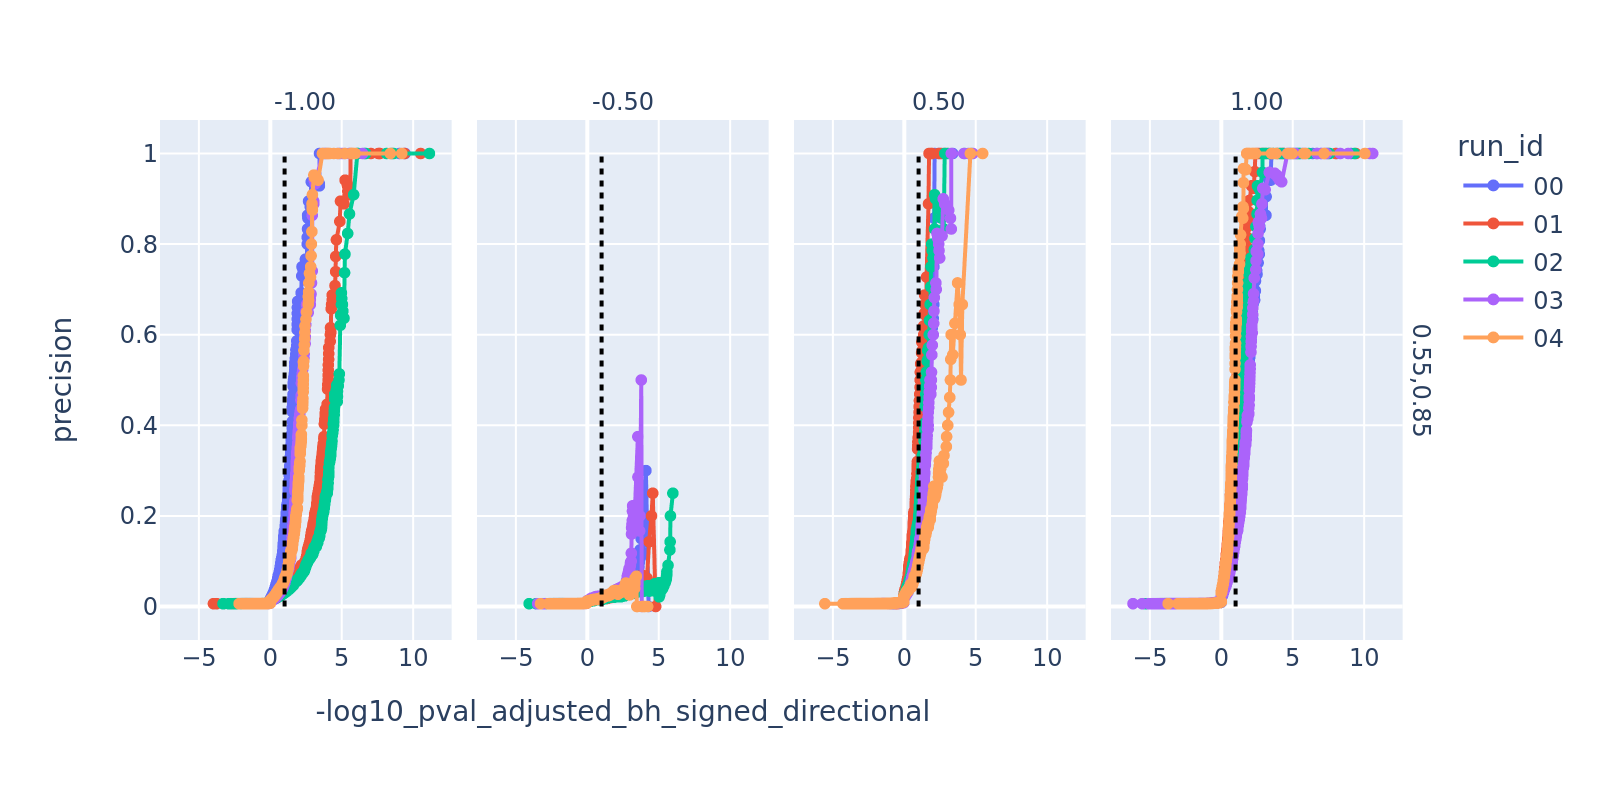

In [21]:
df_to_plot = (
    df_precision_recall_curves
    .xs("0.55,0.85", level="malignant_means", drop_level=False)
    .loc[:, :, "-1.00":"1.00", :]
)
fig = extras.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)


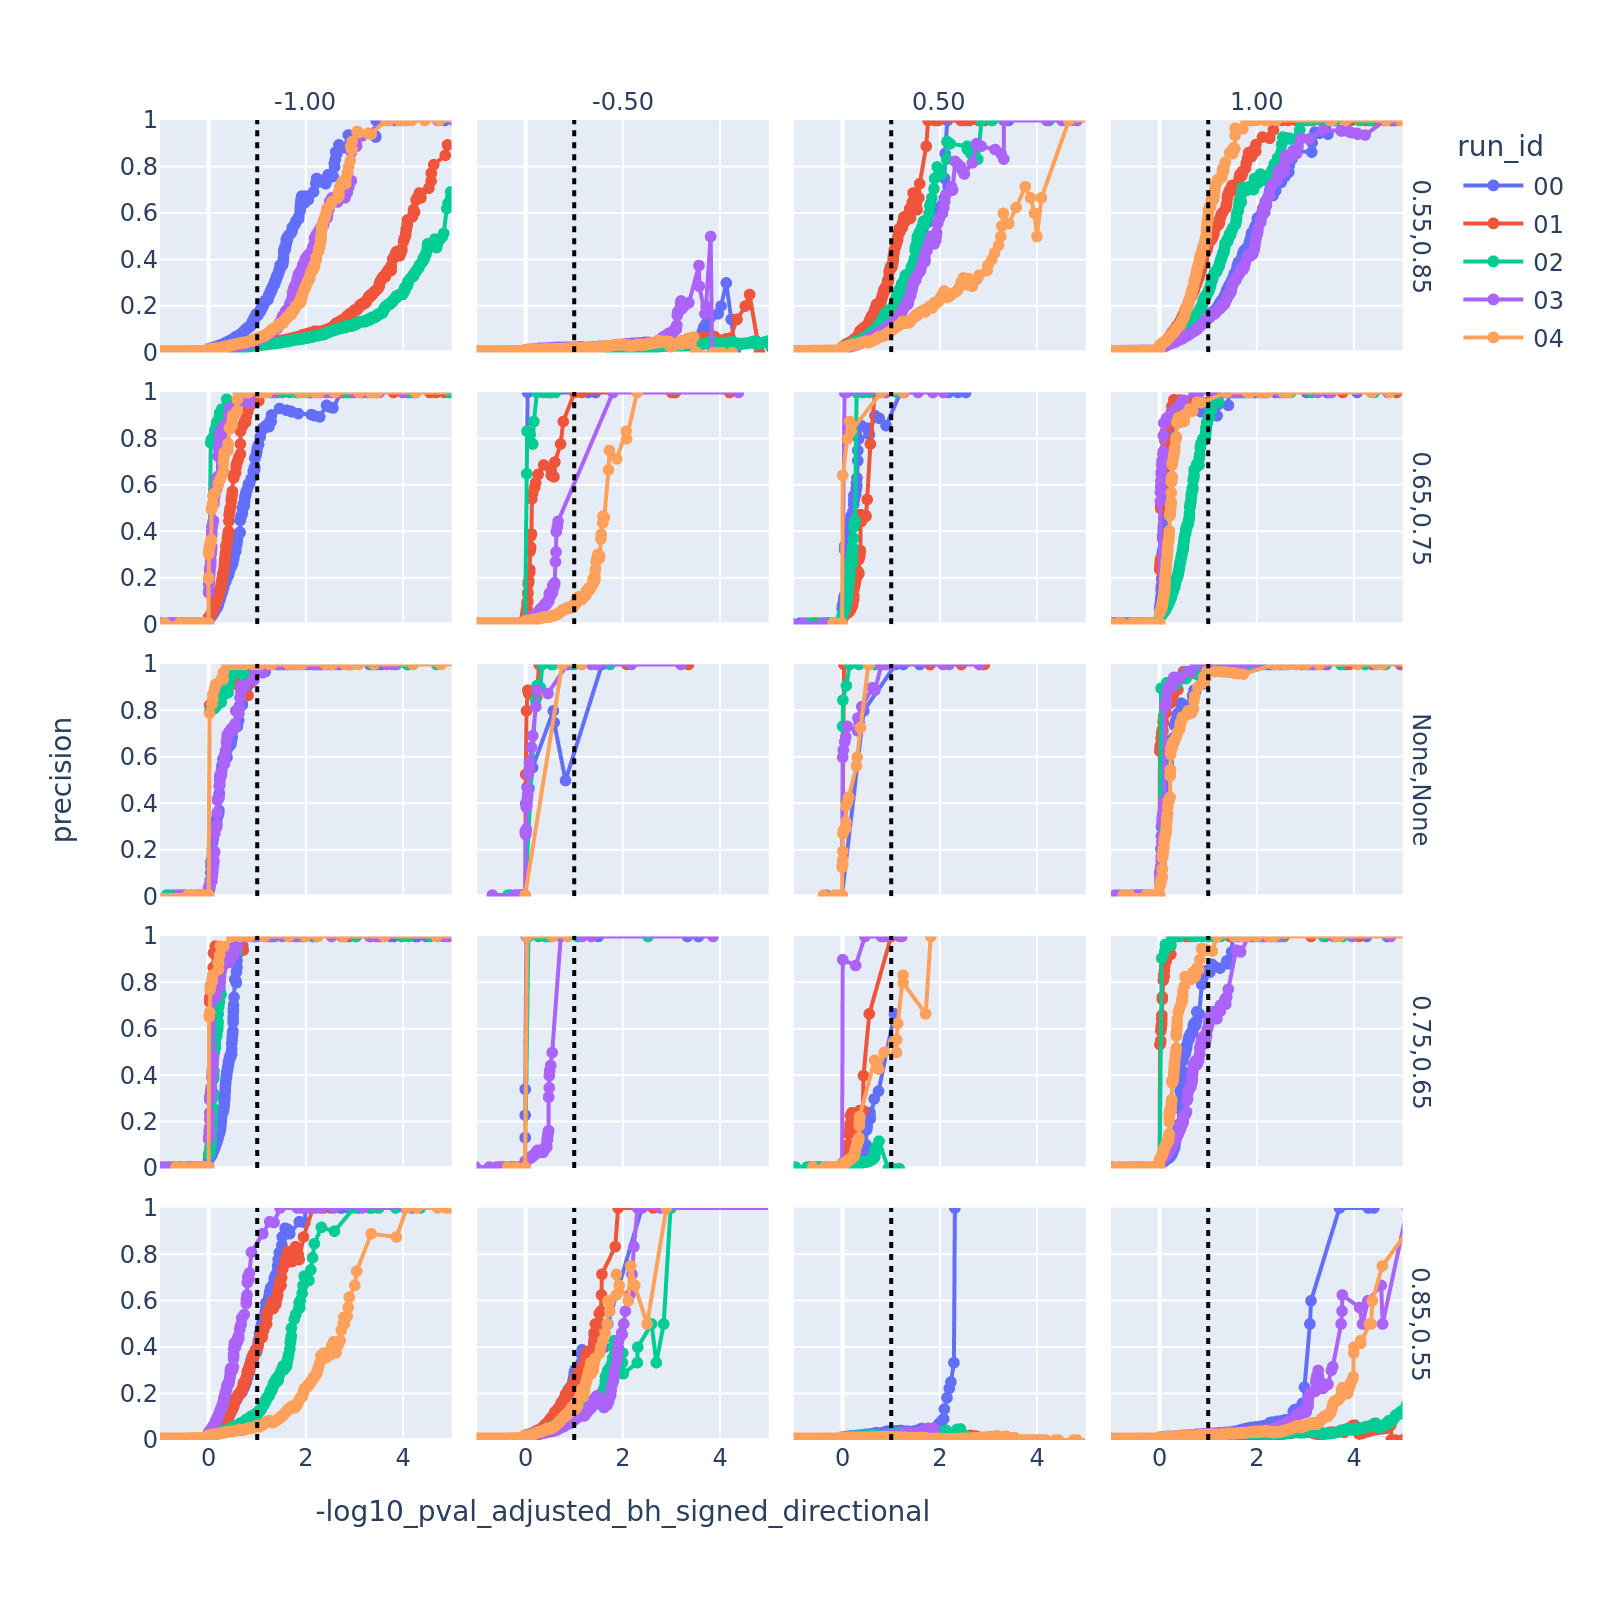

In [23]:
def filter_stuff(df):
    df = df.loc[
        df.index.get_level_values("malignant_means").isin(
            ["0.55,0.85", "0.65,0.75", "None,None", "0.75,0.65", "0.85,0.55"]
        )
    ]
    df = df.loc[:, :, "-1.00":"1.00"]
    return df

fig = extras.plot_metric_by_threshold(
    filter_stuff(df_precision_recall_curves), 
    score_column, 
    "precision",
)
fig.update_layout(width=800, height=800)
fig.update_xaxes(range=[-1, 5])
fig.update_yaxes(range=[0, 1], dtick=0.2)
fig.show(renderer="png", scale=2)

### Precision & Recall curves

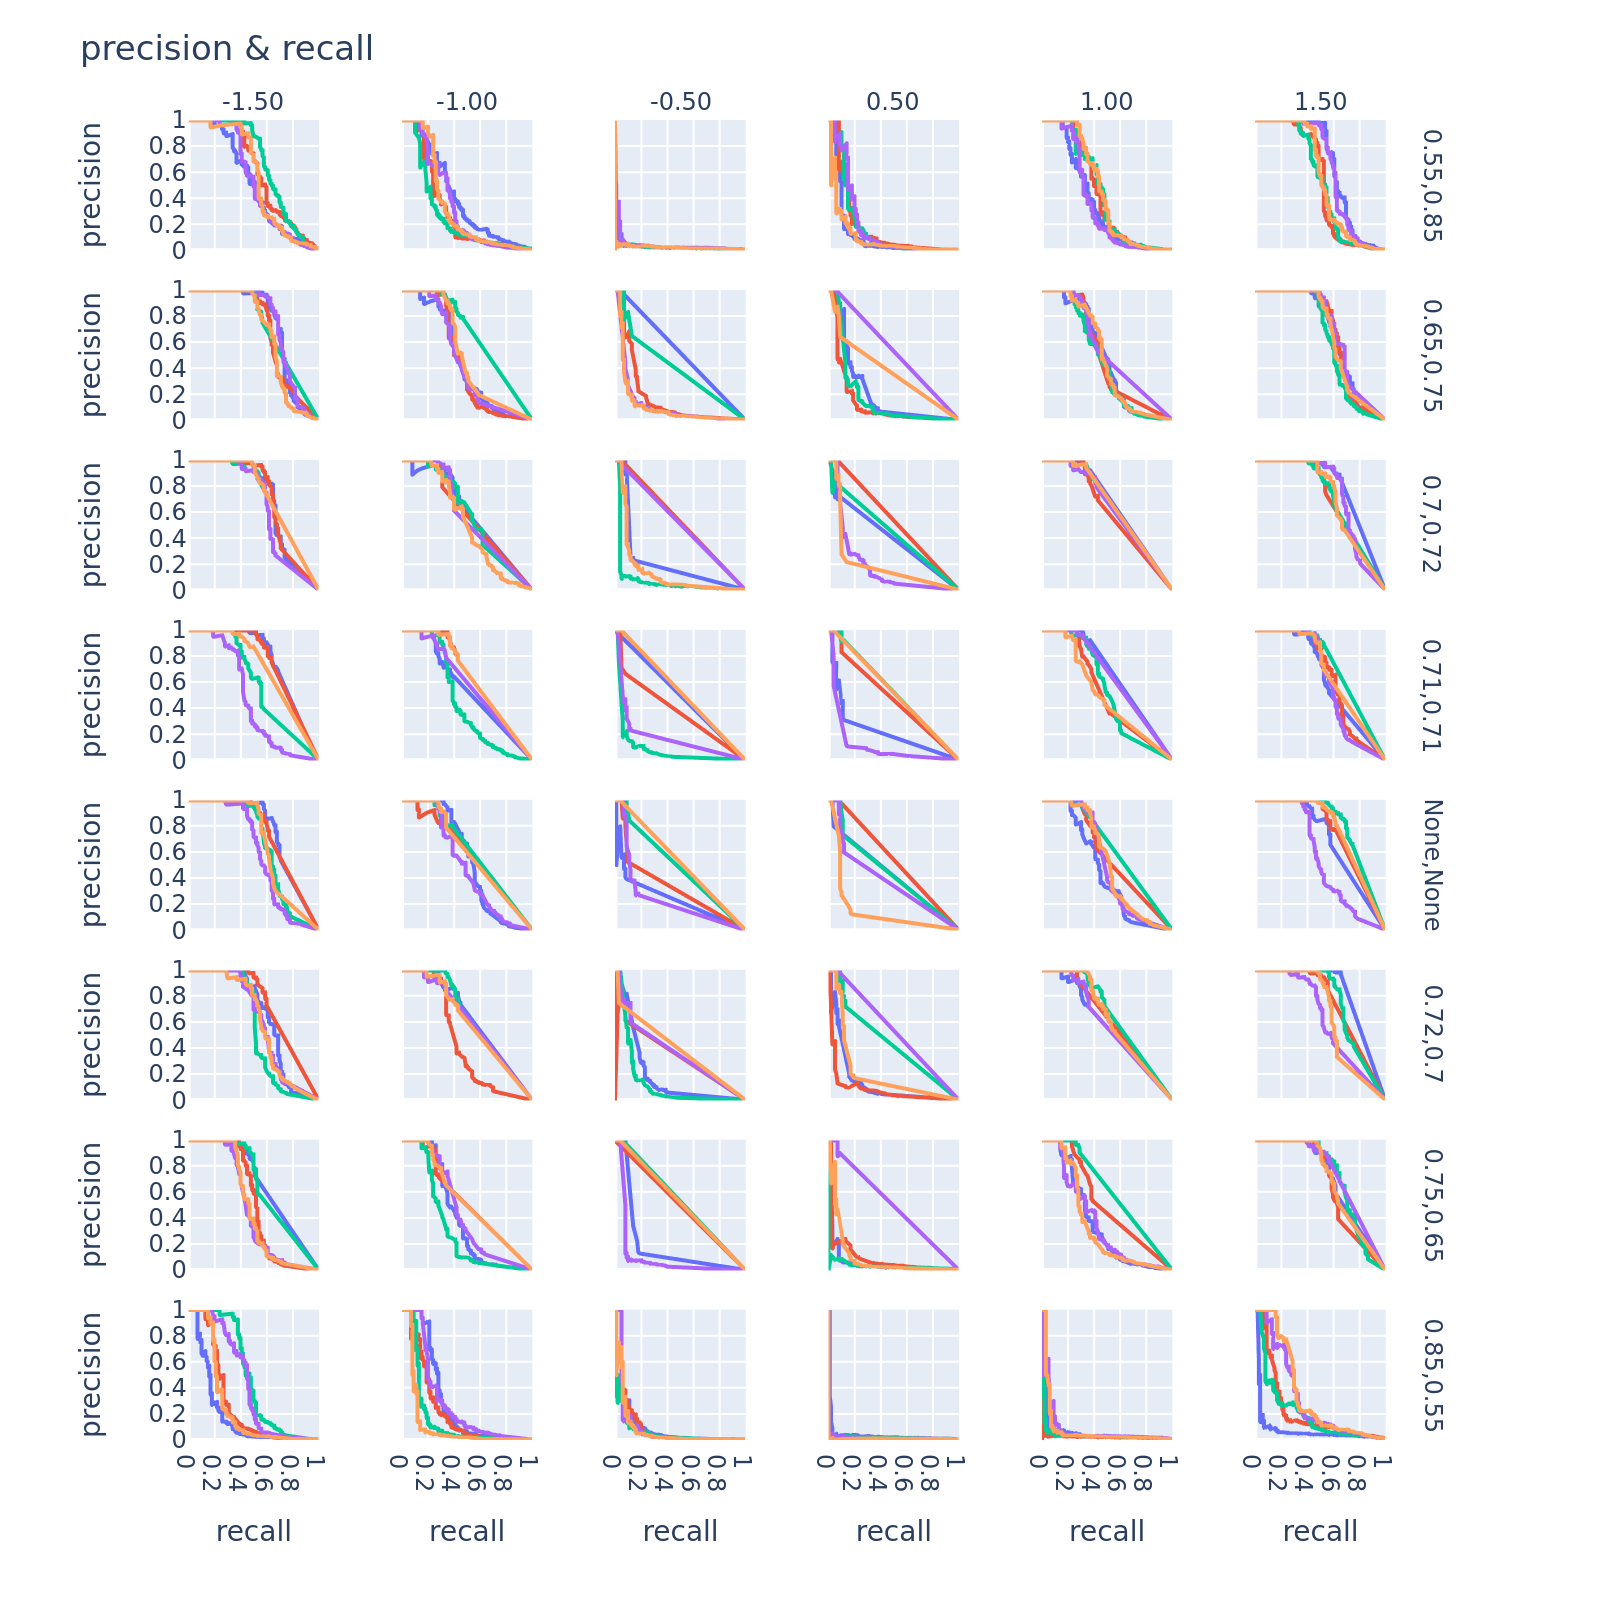

In [17]:
fig = extras.plot_precision_recall_curve(df_precision_recall_curves)
fig.show(renderer="png", scale=2)

### FPR under no perturbation (don't care)

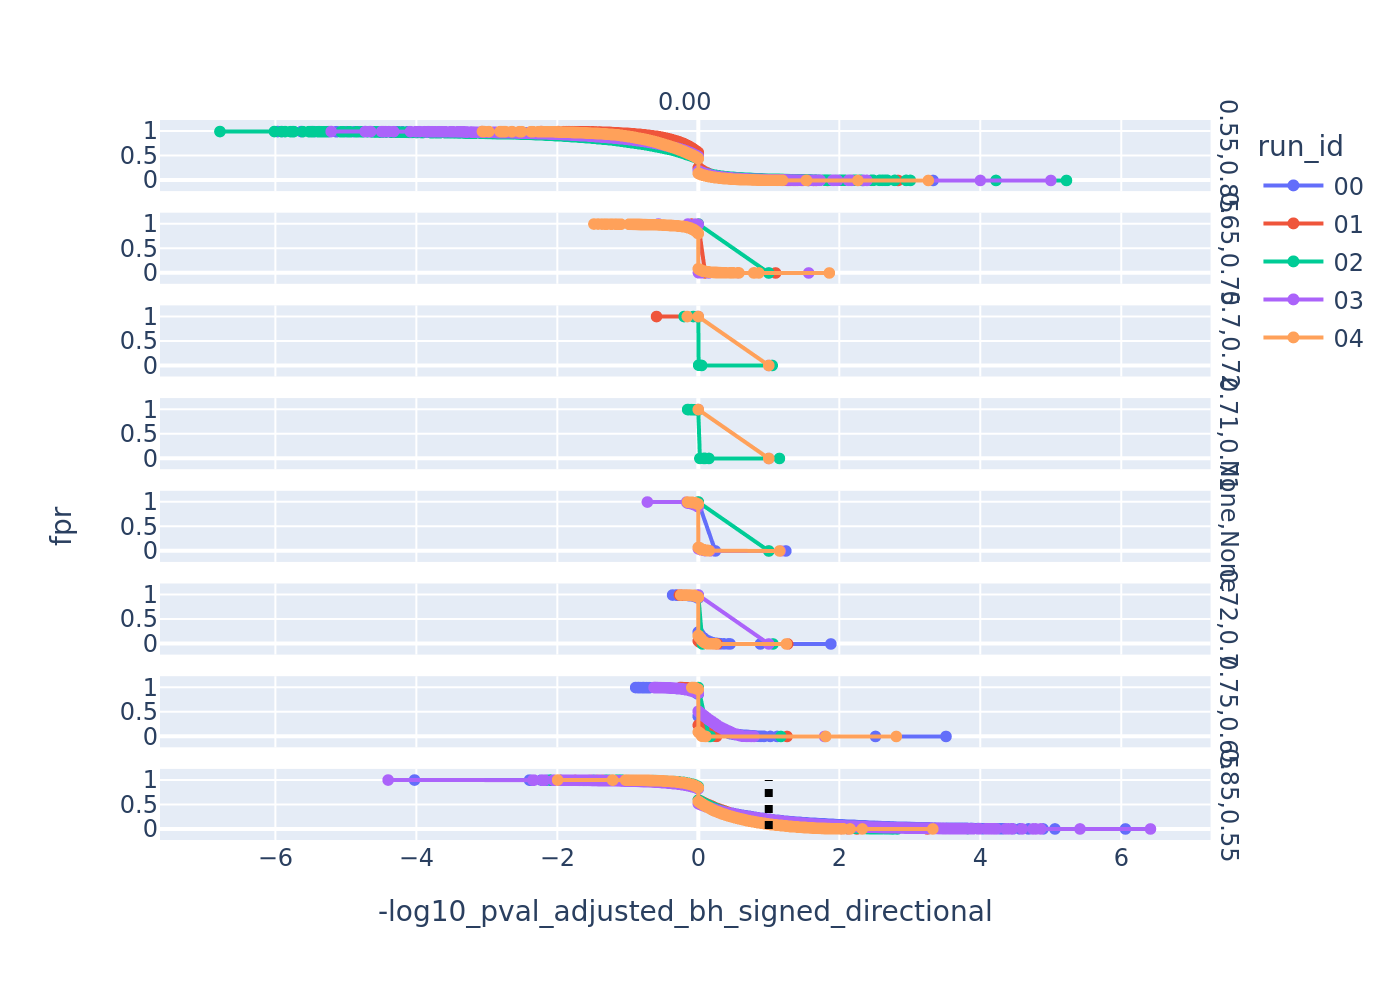

In [18]:
"""
    # .xs(slice("0.65,0.75", None, 3), level="malignant_means", drop_level=False)
"""
subset = (
    df_gene_stats
    .xs("malignant_cibersortx", level="origin", drop_level=False)
    .xs("0.00", level="log2_fc", drop_level=False)
)
df_to_plot, _ = extras.calculate_roc(
    subset,
    score_column
)
fig = extras.plot_metric_by_threshold(df_to_plot, score_column, "fpr")
fig.show(renderer="png", scale=2)

## checking p-values

In [19]:
columns = [
    "pval",
    # "-log10_pval",
    # "-log10_pval_signed_directional",
    # "pval_adjusted_bh",
    # "-log10_pval_adjusted_bh",
    # "-log10_pval_adjusted_bh_signed_directional",
]

# subset_gene_stats = df_gene_stats.loc["malignant_cibersortx", "0.72,0.7", "1.00"]
subset_gene_stats = pd.read_parquet(
    # path_root / "gene_stats" / "malignant_cibersortx" / "0.72,0.7" / "1.00" / "gene_stats.parquet"
    path_root / "experiment_id=264/malignant_means=0.72,0.7/log2_fc=1.00/run_id=04/deg_analysis/gene_stats_malignant_cibersortx.parquet"
    )

print(subset_gene_stats.shape)

# subset_gene_stats[columns].sort_values(by="-log10_pval_adjusted_bh", ascending=False)
print(subset_gene_stats["significant_bh_fdr=0.10"].value_counts())

# plotly line plots of pvals
import plotly.express as px

df_to_plot = subset_gene_stats.sort_values("pval").reset_index()
df_to_plot["perturbed"] = df_to_plot["perturbed"].astype(int)
df_to_plot["size"] = df_to_plot["perturbed"].apply(lambda x: 10 if x == 1 else 5)

fig = px.scatter(
    df_to_plot,
    x="gene_symbol",
    y=columns,
    # use "o" marker if "perturbed" column is True
    color="perturbed",
    size="perturbed",
)
fig

(16063, 10)
False    16036
True        27
Name: significant_bh_fdr=0.10, dtype: int64
